In [2]:
!python -m spacy download en_core_web_lg

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.8.0/en_core_web_lg-3.8.0-py3-none-any.whl (400.7 MB)
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
#import spacy and load the language model downloaded

import spacy
nlp = spacy.load("en_core_web_lg")

### **About Data: News Category Classifier**

Credits: https://www.kaggle.com/code/hengzheng/news-category-classifier-val-acc-0-65


- This data consists of two columns.
        - Text
        - Category
- Text are the description about a particular topic.
- Category determine which class the text belongs to.
- we have classes mainly of 'BUSINESS', 'SPORTS', 'CRIME' and comes under Multi-class classification Problem.

In [21]:
#importing pandas library
import pandas as pd


#reading the dataset "news_dataset.json" provided and load it into dataframe "df"
df = pd.read_json('news_dataset.json')

#printing the shape of data
print(df.shape)

#printing the top5 rows
df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [22]:
#checking the distribution of labels 
df['category'].value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

In [23]:
#Adding the new column which gives a unique number to each of these labels 
df['label_num'] = df['category'].map({'CRIME': 0, 'SPORTS': 1, 'BUSINESS': 2, 'SCIENCE': 3})


#checking the results with top 5 rows
df.head(5) 

,text,category,label_num
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,3
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,3
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,2
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,2
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,0


### **Preprocess the text**

In [24]:
#using this utility function to preprocess the text
#1. Remove the stop words
#2. Convert to base form using lemmatisation


def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return ' '.join(filtered_tokens)

In [25]:
df['preprocessed_text'] = df['text'].apply(lambda text: preprocess(text))

In [26]:
#printing the top 5 rows

df.head()

,text,category,label_num,preprocessed_text
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,3,watch Schrödinger Cat Die University Californi...
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,3,watch freaky Vortex open Flooded Lake
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,2,entrepreneur today need Big Budget start year ...
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,2,Roads recharge Electric Car drive high tech hi...
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,0,Civilian Guard fire Gun protect Recruiting Cen...


In [27]:
df['vector'] = df['preprocessed_text'].apply(lambda text: nlp(text).vector) 

In [28]:
#printing the top 5 rows

df.head()

,text,category,label_num,preprocessed_text,vector
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,3,watch Schrödinger Cat Die University Californi...,"[-0.06900189, 0.12649769, -0.08325721, -0.0683..."
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,3,watch freaky Vortex open Flooded Lake,"[0.18442868, -0.043652277, -0.08334134, -0.073..."
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,2,entrepreneur today need Big Budget start year ...,"[-0.12823991, 0.16327743, -0.018897016, -0.158..."
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,2,Roads recharge Electric Car drive high tech hi...,"[0.27523246, 0.33113563, 0.07515378, -0.249497..."
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,0,Civilian Guard fire Gun protect Recruiting Cen...,"[0.0315163, 0.056255504, 0.13033131, 0.1553470..."


**Train-Test splitting**

In [29]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values, 
    df.label_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.label_num
)

**Reshape the X_train and X_test so as to fit for models**

In [30]:
import numpy as np

print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)


X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (10156,)
Shape of X_test before reshaping:  (2539,)
Shape of X_train after reshaping:  (10156, 300)
Shape of X_test after reshaping:  (2539, 300)


**Attempt 1:**

- use Decision Tree as the classifier.


In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

#1. creating a Decision Tree model object
clf = DecisionTreeClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. getting the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. printing the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.67      0.68       579
           1       0.71      0.73      0.72       833
           2       0.72      0.70      0.71       851
           3       0.54      0.56      0.55       276

    accuracy                           0.69      2539
   macro avg       0.67      0.67      0.67      2539
weighted avg       0.69      0.69      0.69      2539



**Attempt 2:**


- use MultinomialNB as the classifier after applying the MinMaxscaler.

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


#doing scaling because Negative values will not pass into Naive Bayes models
scaler = MinMaxScaler()                                         
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

#1. creating a MultinomialNB model object 
clf = MultinomialNB()

#2. fit with all_train_embeddings and y_train
clf.fit(scaled_train_embed , y_train) 


#3. getting the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(scaled_test_embed)


#4. printing the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81       579
           1       0.83      0.89      0.86       833
           2       0.68      0.93      0.79       851
           3       1.00      0.11      0.20       276

    accuracy                           0.78      2539
   macro avg       0.86      0.66      0.66      2539
weighted avg       0.82      0.78      0.75      2539



**Attempt 3:**

- use KNeighborsClassifier as the classifier after applying the MinMaxscaler.


In [34]:
from  sklearn.neighbors import KNeighborsClassifier


#1. creating a KNN model object
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. getting the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. printing the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       579
           1       0.92      0.89      0.91       833
           2       0.86      0.90      0.88       851
           3       0.92      0.67      0.77       276

    accuracy                           0.88      2539
   macro avg       0.88      0.85      0.86      2539
weighted avg       0.88      0.88      0.88      2539



**Attempt 4:**

- use RandomForestClassifier as the classifier after applying the MinMaxscaler.


In [35]:
from sklearn.ensemble import RandomForestClassifier


#1. creating a Random Forest model object
clf = RandomForestClassifier()


#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. getting the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. printing the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       579
           1       0.86      0.91      0.89       833
           2       0.85      0.90      0.88       851
           3       0.90      0.63      0.74       276

    accuracy                           0.87      2539
   macro avg       0.88      0.83      0.85      2539
weighted avg       0.87      0.87      0.87      2539



**Attempt 5:**

- use GradientBoostingClassifier as the classifier after applying the MinMaxscaler.


In [38]:
from sklearn.ensemble import GradientBoostingClassifier


#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. getting the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. printing the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       579
           1       0.89      0.92      0.90       833
           2       0.88      0.89      0.89       851
           3       0.87      0.77      0.81       276

    accuracy                           0.88      2539
   macro avg       0.88      0.86      0.87      2539
weighted avg       0.88      0.88      0.88      2539



Text(95.72222222222221, 0.5, 'Truth')

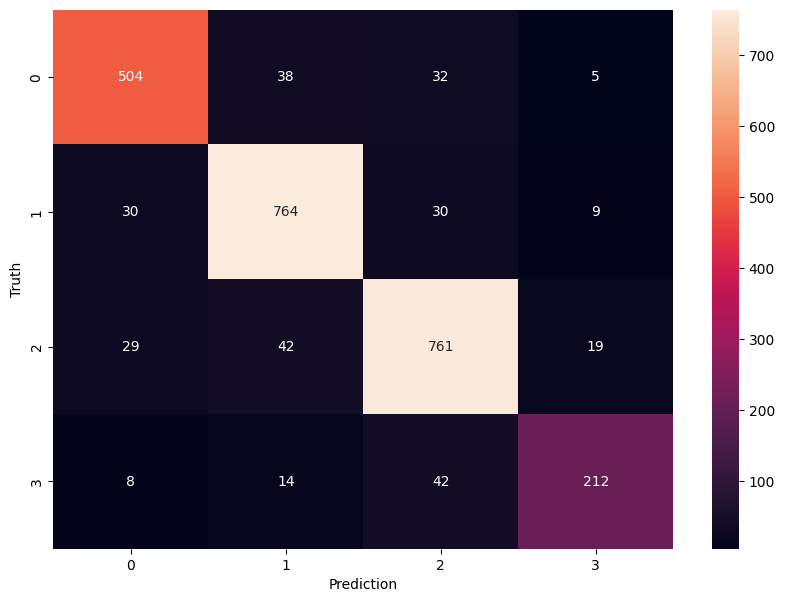

In [39]:
#finally printing the confusion matrix for the best model: GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')